# The untold truth about Wikispeedia (ADAes Team) 

Wikispeedia is a game based on Wikipedia, where players are given a start and end article and they must reach their goal in the fastest time possible only by using Wikipedia hyperlinks.

This study aims at analysing players strategies in order to leverage out insightful conclusions about their navigational behaviour.

Table of content :  
1. [Can this behaviour be generalised](#1.-Can-this-behaviour-be-generalised-?) 
2. [What is the semantic meaning of these paths](#2.-What-is-the-semantic-meaning-of-these-paths-?)
3. [Is this strategy optimal?](#3.-Is-this-strategy-optimal-?)

# Importing Data and Libraries

In [1]:
# Import packages 
import json
import math
import os
import pickle
from ast import literal_eval
from functools import reduce

import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from helpers import *
from matplotlib.pyplot import figure
from numpy import array, average
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import scipy.stats as stats
from scipy.stats import wasserstein_distance
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
# Import data 

#Import DataFrames generated in Data_Engineering.ipynb
df_nodes_topics = pd.read_pickle('data/df_nodes_topics.pkl')
df_nodes = pd.read_pickle('data/df_nodes.pkl')
df_topics_general = pd.read_pickle('data/df_topics_general.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics_df.pkl')
df_out_topics = pd.read_pickle('data/df_out_topics.pkl')
df_in_topics = pd.read_pickle('data/df_in_topics.pkl')
df_paths_finished = pd.read_pickle('data/df_paths_finished.pkl')
df_paths_unfinished = pd.read_pickle('data/df_paths_unfinished.pkl')

# Import NetworkX Graphs generated in Data_Engineering.ipynb
G_topics = nx.read_gpickle('data/G_topics.gpickle')
G_general_topics = nx.read_gpickle('data/G_general_topics.gpickle')
G_articles = nx.read_gpickle('data/G_articles.gpickle')

df_embeddings = pd.read_pickle('data/embeddings.pickle')

# Import useful dicts generated in Data_Engineering.ipynb
with open('data/closeness_dict.pkl','rb') as f:
    closeness_dict = pickle.load(f)
with open('data/closeness_topics_dict.pkl','rb') as f:
    closeness_topics_dict = pickle.load(f)  
with open('data/pagerank_topics_dict.pkl','rb') as f:
    pagerank_topics_dict = pickle.load(f)  

with open('data/pagerank_dict.pkl','rb') as f:
    pagerank_dict = pickle.load(f)  
    
with open('data/betweenness_dict.pkl','rb') as f:
    betweenness_dict = pickle.load(f)
with open('data/betweenness_topics_dict.pkl','rb') as f:
    betweenness_topics_dict = pickle.load(f)    

In [3]:
# We define the constatns for the analysis
OUT_DEGREE = 'out_degree'
CLOSENESS = 'closeness'
PAGERANK = 'pagerank'
BETWEENNESS = 'betweenness'
SEMANTIC = 'sematic similarity'
CENTRALITY_MEASURES = [OUT_DEGREE, CLOSENESS, PAGERANK, BETWEENNESS]

AVERAGE_PATH_LENGTH = round(df_paths_finished['path_length'].mean())
K = 12

In [4]:
# We define the data schema for the analysis
class DataSchema :
    """This class defines the data schema for the analysis
    """

    START = 'start'
    TARGET = 'target'
    PATH = 'path'
    VISITS = 'visits'
    DURATION = 'durationInSec'
    PATH_LENGTH = 'path_length'
    TIME_PER_ARTICLE = 'time_per_article'
    TYPE = 'type'



# 1. Is there a behaviour that can be generalized ?

## 1.1 Are the most central nodes the most visited ones ? 

### 1.1.1 What are the most central nodes ?

In [5]:
# We rank the nodes according to diffenrent centrality measures and store the results in a DataFrame
df_order_per_metric = pd.DataFrame(columns=CENTRALITY_MEASURES, index=['Rank {}'.format(i+1) for i in range(df_nodes.shape[0])])
for measure in CENTRALITY_MEASURES:
    df_order_per_metric[measure] = df_nodes.sort_values(by=measure, ascending=False).reset_index()['name'].tolist()
df_order_per_metric.columns = pd.MultiIndex.from_product([['Centrality Measures'], df_order_per_metric.columns])

In [6]:
# We print the most central nodes according to the different centrality measures
print('The most central nodes according to the different centrality measures are:')
df_ranked_metrics = df_order_per_metric
df_ranked_metrics.head(AVERAGE_PATH_LENGTH)

The most central nodes according to the different centrality measures are:


Centrality Measures                                                  
                out_degree       closeness          pagerank     betweenness
Rank 1       United_States   United_States     United_States   United_States
Rank 2      United_Kingdom          Europe            France  United_Kingdom
Rank 3              France  United_Kingdom            Europe         England
Rank 4              Europe          France    United_Kingdom          Europe
Rank 5             England         Germany  English_language          Africa
Rank 6        World_War_II    World_War_II           Germany         Germany

It is often the case in real-world networks, that the degree distribution is skewed. As this fact is of high interest for our analysis, we decide to visualise it.

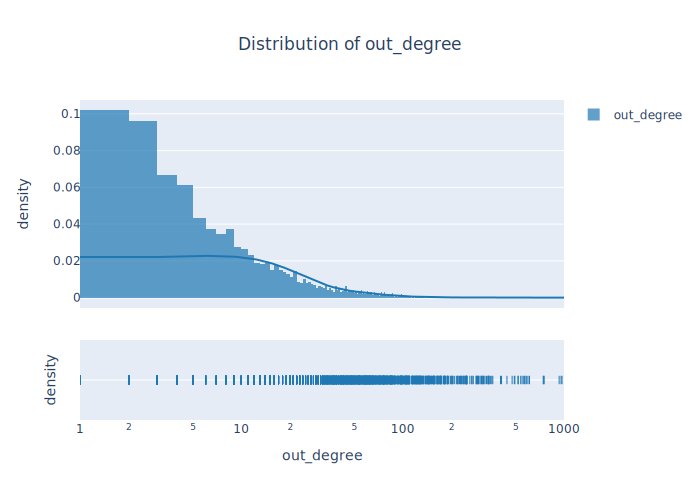

In [7]:
# plot histogram of out_degree in df_nodes
fig = ff.create_distplot([df_nodes[OUT_DEGREE]], ['out_degree'], bin_size=1)
fig.update_layout(title_text='Distribution of out_degree', title_x=0.5)
fig.update_xaxes(type="log", range=[0, 3], title_text='out_degree'),
fig.update_yaxes(title_text='density')
fig.show(renderer='svg')

### 1.1.2 What are the most visited nodes ? 

In [8]:
# We sort and display the most visited nodes 
print('The most visited nodes are :')
display(df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)[[DataSchema.VISITS]].head(AVERAGE_PATH_LENGTH))

The most visited nodes are :


,visits
name,
United_States,11991.0
Europe,5397.0
United_Kingdom,5021.0
England,4255.0
Earth,4095.0
Africa,3446.0


### 1.1.3 Are the most central nodes the most visited ones ?

In [9]:
# We add columns for the rank of each article in each centrality measure
for measure in CENTRALITY_MEASURES: 
    df_nodes[measure+'_rank'] = df_nodes[measure].rank(ascending=False)

# We add a column for the rank of each article in terms of visits
df_nodes[DataSchema.VISITS+'_rank'] = df_nodes[DataSchema.VISITS].rank(ascending=False)

In [10]:
# We sort and display the articles and their rank in each centrality measure
df_nodes = df_nodes.sort_values(by=DataSchema.VISITS, ascending=False)
df_nodes[[DataSchema.VISITS+'_rank', 'out_degree_rank', 'closeness_rank', 'betweenness_rank', 'pagerank_rank']].head(AVERAGE_PATH_LENGTH)

,visits_rank,out_degree_rank,closeness_rank,betweenness_rank,pagerank_rank
name,,,,,
United_States,1.0,1.0,1.0,1.0,1.0
Europe,2.0,4.0,2.0,4.0,3.0
United_Kingdom,3.0,2.0,3.0,2.0,4.0
England,4.0,5.5,10.0,3.0,8.0
Earth,5.0,49.0,56.0,11.0,35.0
Africa,6.0,20.0,23.0,5.0,20.0


In [11]:
# We choose the Wasserstein distance to measure how close are the ranks of the centrality measures and the visits
dist = [wasserstein_distance(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank']) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The waterstein distance between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))


The waterstein distance between the visits and out_degree is 17.266072980017373
The waterstein distance between the visits and closeness is 19.434622067767144
The waterstein distance between the visits and pagerank is 19.822328410078182
The waterstein distance between the visits and betweenness is 45.19113814074715


In [12]:
# We choose mean squared error to measure how close are the ranks of the centrality measures and the visits
dist = [mean_squared_error(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank'], squared=False) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The mean squared error between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))

The mean squared error between the visits and out_degree is 748.9033172906907
The mean squared error between the visits and closeness is 766.9629173810858
The mean squared error between the visits and pagerank is 858.9102120648158
The mean squared error between the visits and betweenness is 888.6690326234368


In [13]:
# We choose mean absolute error to measure how close are the ranks of the centrality measures and the visits
dist = [mean_absolute_error(df_nodes[DataSchema.VISITS+'_rank'], df_nodes[measure+'_rank']) for measure in CENTRALITY_MEASURES]
dist.sort()
for d in dist:
    print('The mean absolute error between the visits and {} is {}'.format(CENTRALITY_MEASURES[dist.index(d)], d))

The mean absolute error between the visits and out_degree is 550.1859252823632
The mean absolute error between the visits and closeness is 563.7208948740226
The mean absolute error between the visits and pagerank is 620.3998696785404
The mean absolute error between the visits and betweenness is 649.8464378801043


As we can see, the most visited nodes also perfom strongly on centrality measures. This confirms our intuition about players' strategy and the fact that they have a tendency to visit more central nodes.

Moreover, we try different metrics to measure which centrality measure best reflects the visits of the players. We observe that all the metrics yield the same answer and we can safely conclude that the out-degree best represents the behavior of the players. 

## 1.2 What is the evolution of the centrality of the nodes visited in the players' path ?

In [14]:
# We use a helper function to obtain the average evolution of the centrality measure for the top k most played games
evolution_centrality = get_values_plot(df_paths_finished, K, OUT_DEGREE, df_nodes)

In [15]:
# We use a helper funtion to plot the average evolution of the centrality measure for the top k most played games
plot_average_evolution(evolution_centrality, OUT_DEGREE)

In [16]:
# We emphasize statistical significance based on how many players are involved in this study 
print('The number of unique players to have participated in this study is :', get_number_players(df_paths_finished, get_top_k_games(df_paths_finished, K)))

The number of unique players to have participated in this study is : 2736


This study realised above further confirms our intution about players' strategy. We can clearly observe the evolution of the centrality measure along the path, and we see that players first move towards central nodes before focusing back on the target. 

This conclusion draws it's statistical significance from the confidence intervals of the curves as each curve was obtained by averaging many paths played. Moreover, 2736 players were involved in this study. 
Both those arguments make a solid statement that this behaviour is generalisable as we observe a great number of players converging towards the same strategy.

## 1.3 What is the evolution of the centrality of the nodes visited in the shortest path ? 

In [17]:
# We use the helper function to get the evolution of the centrality measure for the shortest path
evolution_centrality_shortest_path = get_centrality_shortest_path(df_paths_finished, G_articles, df_nodes, OUT_DEGREE, K)

In [18]:
plot_evolution_shortest_path(evolution_centrality_shortest_path, OUT_DEGREE)

We observe that the evolution of the centrality of the nodes visited along the shortest path follow a similar behavior to the players. This can be explained by properties of real world networks. Degree distribution tends to be skewed, and some nodes effectively act as hubs and allow for very short paths to be found. Moreover, in such networks, short paths are easily discoverable via greedy decentralized routing. In light of that, we conclude that shortest paths follow this centrality evolution as shortest paths tend to go through hubs. And players also follow a similar strategy by greed, although they do not always find the **shortest** path.

# 2. What is the semantic meaning of the players' paths ?

## 2.1 Is the player getting semantically closer to the goal ?

In [19]:
# We use the helper function to get the evolution of the semantic over the top k most played paths 
evolution_semantic = get_values_plot(df_paths_finished, K, SEMANTIC, df_embeddings=df_embeddings)

In [20]:
# We use the helper function for the plot
plot_average_evolution(evolution_semantic, SEMANTIC)

From the above plots, we see that players reason logically about their choices. There is a clear notion of semantic in the decisions of the players as the semantic similarity increases along the path. This unveils the full strategy of the players' as not only do they tend to go through central nodes, but they also factor in semantic closeness to the target when making their choice.

## 2.2 Does shortest path reflect semantic closeness/similarity ?

In [21]:
# We use the helper function to get the evolution of the semantic over the shortest path
evolution_semantic_shortest_path = get_sim_shortest_path(25 ,G_articles,df_paths_finished,df_embeddings)

In [22]:
# We use the helper function to plot 
plot_evolution_shortest_path(evolution_semantic_shortest_path, SEMANTIC)

From the above plots, we discover a major difference that keeps the players from reaching the shortest paths. Indeed, shortest paths do not seem to follow semantic distance in the path, which is counter intuitive for human players but allows algorithms with a global view of the network to find the optimal routing. 

Furthermore, we decide to compute the proportion of shortest paths that follow a strictly increasing semantic.

In [23]:
# This function yields the proportion of shortest paths for the top k games that have strictly increasing semantic 
def check_k_path_increasing(df_paths_finished, df_embeddings, G_articles, k):

    def check_condition(arr):
        if(len(arr) <= 1):
            return True
        return all(arr[i] >= arr[i-1] for i in range(1, len(arr)))

    df_all = (
        df_paths_finished[[DataSchema.START, DataSchema.TARGET, DataSchema.PATH]]
        .groupby([DataSchema.START, DataSchema.TARGET])
        .count()
        .sort_values(by=DataSchema.PATH, axis=0, ascending=False)[:k]
    )
    all_games = df_all.index
    paths = []
    for start, target in all_games:
        for path in nx.all_shortest_paths(G_articles, start, target):
            paths.append(path)

    counter = 0 
    for path in paths: 
        sim = compute_cosine_similarity(df_embeddings, path[:-1], path[-1])
        sim = [item for sublist in sim for item in sublist]
        counter = counter + 1 if check_condition(sim) else counter

    counter = counter/len(paths)

    return counter

In [24]:
counter = check_k_path_increasing(df_paths_finished, df_embeddings, G_articles, 1000)
print("Proportion of shortest paths for the top 1000 games that have strictly increasing semantic : {:.2f}%".format(counter*100))

Proportion of shortest paths for the top 1000 games that have strictly increasing semantic : 40.73%


### Now that we have unveiled deeper insights about players' behavior and what keeps them from reaching optimality in the Wikispeedia game, we decide to investigate further improvements that can help players get closer to the shortest path.

# 3. Are there any startegies to avoid ? 

## 3.1 How do people that do not succeed behave ? 

In [25]:
# We only keep meaningful paths
df_unfinished_played = df_paths_unfinished[df_paths_unfinished['path'].apply(lambda x : len(x)>1)]

In [26]:
# We use the helper function to get the evolution of the centrality measure for the top k most played games over unfinished paths
evolution_centrality_unfinished = get_values_plot(df_unfinished_played, K, OUT_DEGREE, df_nodes)

In [27]:
# We use the helper function to plot 
plot_average_evolution(evolution_centrality_unfinished, OUT_DEGREE)

From the above plots, it becomes clear that people who do not manage to finish their paths are not following the same strategy as the winners. As we can observe, the out-degree evolution over the path behaves differently from winner paths. They often keep trying to find more general pages (i.e. with higher out degree) and fail to narrow back down to the target later. 

In light of this discovery, we decide to investigate potential differences in the decision making behavior between winner and loosers.

## 3.2 How do they differ from winner in their decision making ?

An interesting point to analyse here is the time spent per article by the winner and the loosers. This may yield further insights about their decision making behaviour.

In [28]:
# remove rows where type = timeout
df_paths_unfinished = df_paths_unfinished[df_paths_unfinished[DataSchema.TYPE] != 'timeout']

In [29]:
avg_finished = df_paths_finished[DataSchema.TIME_PER_ARTICLE].mean()
avg_unfinished = df_paths_unfinished[DataSchema.TIME_PER_ARTICLE].mean()
print('The average time spent per article for finished paths is {:.2f} seconds'.format(avg_finished))
print('The average time spent per article for unfinished paths is {:.2f} seconds'.format(avg_unfinished))

The average time spent per article for finished paths is 24.89 seconds
The average time spent per article for unfinished paths is 45.97 seconds


In [30]:
stat, p_value = stats.ttest_ind(df_paths_finished[DataSchema.TIME_PER_ARTICLE], df_paths_unfinished[DataSchema.TIME_PER_ARTICLE], alternative='less', equal_var=False)
print('The p-value for the t-test is {:.2f}'.format(p_value))

The p-value for the t-test is 0.00


In [31]:
# Function that tests the hypothesis that the time_per_article is lower in finished games than in unfinished games (using Bejamini-Hochberg correction)
def get_k_BH_test(df_paths_finished, df_paths_unfinished, k, alpha=0.05):
    topk = get_top_k_games(df_paths_finished, k)
    summary = {}

    for start, target in topk:
        fin = df_paths_finished[(df_paths_finished[DataSchema.START] == start) & (df_paths_finished[DataSchema.TARGET] == target)][DataSchema.TIME_PER_ARTICLE]
        unfin = df_paths_unfinished[(df_paths_unfinished[DataSchema.START] == start) & (df_paths_unfinished[DataSchema.TARGET] == target)][DataSchema.TIME_PER_ARTICLE]
        _, p_value = stats.ttest_ind(fin, unfin, alternative='less', equal_var=False)
        summary[(start, target)] = p_value

    summary = dict(sorted(summary.items(), key=lambda item: item[1]))

    for count, (key, value) in enumerate(summary.items()):
        thresh = ((count + 1) * alpha) / k
        summary[key] = (value, value < thresh)

    for key, value in summary.items():
        print('{} to {} : p_value = {:.3f}, reject_null = {}'.format(key[0], key[1], value[0], value[1]))

In [32]:
get_k_BH_test(df_paths_finished, df_paths_unfinished, K)

Brain to Telephone : p_value = 0.000, reject_null = True
Pyramid to Bean : p_value = 0.000, reject_null = True
Asteroid to Viking : p_value = 0.000, reject_null = True
Batman to Wood : p_value = 0.000, reject_null = True
Cat to Computer : p_value = 0.003, reject_null = True
Beer to Sun : p_value = 0.005, reject_null = True
Bird to Adolf_Hitler : p_value = 0.007, reject_null = True
Batman to Banana : p_value = 0.016, reject_null = True
Cat to Microsoft : p_value = 0.022, reject_null = True
Batman to The_Holocaust : p_value = 0.027, reject_null = True
Theatre to Zebra : p_value = 0.028, reject_null = True
Bird to Great_white_shark : p_value = 0.061, reject_null = False


All the hypothesis testing point towards the fact that winners spend less time per article than loosers. This yields insights about their decision making. If you spend less time per article, you have less time to focus on semantics and choose the "perfect" next node. If you oblige yourself to go fast, than it is the best way for you to make choices that are not semantically perfect. In that sense, you get closer to the behaviour of the shortest path.

# Final Wrap Up

Now that we have analysed every potential aspect of the game using the data available, let’s wrap up all what we have found. To get an optimal path, it’s crucial to first attain a general article from which you can reach more specific articles. Examples of such articles include “Earth”, “USA”,”Europe”. To find a similar one, you might ask yourself the following question: By accessing this article, will I have a wide range of options from which to choose my next hop? If the answer is yes, then you got it. Once you find such an article, you should immediately start going more specific and try to get closer to your target. Obviously, if your target is of a general topic like “United Kingdom”, you don’t need to go through this step. This is, however, very rare due to skewed degree distribution of nodes in the graph, the reason for which we did not base our analysis on such outliers.

Going through the article’s text, you might naturally find yourself attempting to get closer to your target semantically. That is you try to find articles that have similar connotations and talk about close topics. Just don’t do it! In fact, you will waste a lot of time reading the articles just to follow a strategy which is not even optimal. 
Following these tips is guaranteed and proven by our data to work and to actually yield the optimal path. Now that you have mastered the art of Wikispeedia, why don’t you try again and see how these tips will improve your game.
